# AIM-SR

*Sign recognition demo using the BrainForge library*

**Author**: Csaba Gór

This notebook illustrates the usage of the *BrainForge* Neural Network library. The library can be obtained by issuing the following *pip* command:

```pip install git+https://github.com/csxeba/brainforge.git```

Since this demonstration also depends on other packages, a *conda* environment descriptor *YaML* file is supplied (*env.yml*). This environment can be set up by issuing the following *conda* command:

```conda env create -f env.yml```

In [1]:
import numpy as np

from brainforge import Backpropagation, LayerStack
from brainforge import layers, optimizers

## Dataset

The dataset which is going to be fit is a **road sign recognition** dataset, which can either be downloaded and extracted to this project's *data/* folder using the *data/get.sh* script or the dataset root can also be specified below if the dataset is already available.

The model performance will be monitored on a validation subset, which is a 20% split from the training set. The validation set is always the last 20% of the images of every class, determined by the increasing sorting order of their file names.

In [2]:
DATASET_ROOT = "data/train-52x52"

In [3]:
import data

dataset = data.Dataset(root=DATASET_ROOT, split_validation=0.2, image_format="channels_first")

 [Streamer] - Num train samples: 48000
 [Streamer] - Num val samples: 12000


## Model

The data is fit by an *Artificial Neural Network*, more specifically a *Fully Convolutional Neural Network*, which has a relatively low number of parameters and thus (hopefully) generalizes better than a classic CNN with a Dense head.

The network weights are optimized by *Stochastic Gradient Descent* on the gradients determined by *Backpropagation*. The model output activation and loss functions are chosen so that they reflect the *multiclass classification* nature of the problem. The optimizer is chosen to be the *Adam* optimizer [Kigma & Ba, 2015](https://arxiv.org/abs/1412.6980), which is more-or-less a default choice for the optimizer and tends to perform adequately.

In [4]:
stack = LayerStack(dataset.input_shape, layers=[
    
    layers.ConvLayer(nfilters=16, filterx=5, filtery=5, compiled=True),
    layers.PoolLayer(filter_size=2, compiled=True),
    layers.Activation("relu"),

    layers.ConvLayer(nfilters=32, filterx=5, filtery=5, compiled=True),
    layers.Activation("relu"),

    layers.ConvLayer(nfilters=32, filterx=5, filtery=5, compiled=True),
    layers.PoolLayer(filter_size=2, compiled=True),
    layers.Activation("relu"),

    layers.ConvLayer(nfilters=dataset.NUM_CLASSES, filterx=5, filtery=5, compiled=True),

    layers.GlobalAveragePooling(),
    layers.Activation("softmax"),
])

## Training

The training takes about 1.5 hours and the network reaches over 99% accuracy on the validation set, which is unnaturally high and is caused probably by the fact that the validation set is highly similar to the training set.

Below are the parameters for the training. Previous experiments showed that *6 epochs* are sufficient to reach convergence on this dataset. The relatively *low batch size* and *high learning rate* ensures the network jumps out of smaller local minima and finds a good optimum with good generalization. Together with the fully convolutional nature of the architecture, this produces sufficient regularization, so no additional regularization was required.

A validation increase factor is applied to better monitor the development of the target KPI, which is the classification accuracy on the validation set.

In [5]:
EPOCHS = 6
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
VALIDATION_INCREASE_FACTOR = 4  # divides steps per epoch and multiplies epochs

In [6]:
trainer = Backpropagation(layerstack=stack, cost="cxent", optimizer=optimizers.Adam(LEARNING_RATE))

trainer.fit_generator(dataset.iter_subset("train", BATCH_SIZE),
                      lessons_per_epoch=dataset.steps_per_epoch("train", BATCH_SIZE) // VALIDATION_INCREASE_FACTOR,
                      epochs=EPOCHS * VALIDATION_INCREASE_FACTOR,
                      metrics=["acc"],
                      validation=dataset.iter_subset("val", BATCH_SIZE),
                      validation_steps=dataset.steps_per_epoch("val", BATCH_SIZE))

# Save the weights as NumPy vector.
weights = stack.get_weights(unfold=True)
np.save("AIM-SR-weights.npy", weights)

Epoch  1/24
Training Progress: 100.0%  cost: 0.7427 accuracy: 0.7172 Validation cost: 0.4020 accuracy: 0.8469
 took 5.12 minutes
Epoch  2/24
Training Progress: 100.0%  cost: 0.3073 accuracy: 0.9009 Validation cost: 0.2532 accuracy: 0.9218
 took 4.61 minutes
Epoch  3/24
Training Progress: 100.0%  cost: 0.1960 accuracy: 0.9428 Validation cost: 0.1495 accuracy: 0.9641
 took 4.40 minutes
Epoch  4/24
Training Progress: 100.0%  cost: 0.1376 accuracy: 0.9616 Validation cost: 0.1293 accuracy: 0.9667
 took 4.23 minutes
Epoch  5/24
Training Progress: 100.0%  cost: 0.0997 accuracy: 0.9735 Validation cost: 0.1129 accuracy: 0.9657
 took 4.17 minutes
Epoch  6/24
Training Progress: 100.0%  cost: 0.0829 accuracy: 0.9788 Validation cost: 0.0681 accuracy: 0.9822
 took 4.06 minutes
Epoch  7/24
Training Progress: 100.0%  cost: 0.0674 accuracy: 0.9835 Validation cost: 0.0523 accuracy: 0.9889
 took 4.00 minutes
Epoch  8/24
Training Progress: 100.0%  cost: 0.0531 accuracy: 0.9863 Validation cost: 0.0466 accu

Applying early stopping, regularization, augmentation, batch normalization and bigger architectures was considered, but rejected, because the score is already high enough, so no additional complexity was required.

## Inference

Let's set up some functions to aid testing the network on arbitrary input images.

In [7]:
NETWORK_WEIGHTS = "AIM-SR-weights.npy"

stack.set_weights(np.load(NETWORK_WEIGHTS), fold=True)

def preprocess_image(image):
    x = image / 255.  # Downscale to range 0. - 1.
    x = x.transpose((2, 0, 1))  # Convert to channels first
    return x[None, ...]  # Add a batch dimension

def execute_inference(image: np.ndarray) -> int:
    """
    Runs preprocessing, executes the network and returns an integer label.
    Returned labels are indexed from 1, just like in the dataset.
    
    image: np.ndarray
        Single BGR image as a 3D numpy array in channels last format.
    """
    
    x = preprocess_image(image)
    output = stack.feedforward(x)[0]  # eliminate batch dim
    prediction = np.argmax(output) + 1
    return prediction


Below is a demonstration on how to run inference on an arbitrary image and check whether the predicted label is correct.

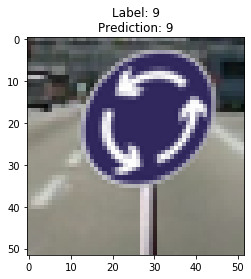

In [8]:
import cv2
from matplotlib import pyplot as plt

# Paths are stored as pathlib.Path objects. Let's free the path strings from their misery.
# Validation was split from the last 20% of every label, so taking the last image is OK
# for this demostration. The network did not see this image during training.
image_path = str(dataset.paths[-1])

# Note that OpenCV reads the images in a BGR format by default,
# which is not the case with eg. PIL, SciPy, ImageIO, etc.
image = cv2.imread(image_path)

# This is the label corresponding to the image above.
label = dataset.labels[-1] + 1  # Restore 1-based indexing

prediction = execute_inference(image)

plt.imshow(image[..., ::-1])  # convert image to RGB
plt.title(f"Label: {label}\nPrediction: {prediction}")
plt.show()